In [183]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

### Load the UCI Bank Marketing dataset

In [200]:
# Load the csv into a pandas DataFrame

bank_dataframe = pd.read_csv('data/bank.csv', delimiter=';')

In [201]:
# Show the head of the dataFrame

bank_dataframe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [202]:
# Print the shape of the dataframe

print(bank_dataframe.shape)

(4521, 17)


In [203]:
# Select the features from the dataset

features = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
           'loan', 'contact', 'campaign', 'pdays', 'poutcome']

labels = ['y']

bank_dataframe = bank_dataframe.filter(features + labels)

In [204]:
# Show the head of the dataframe

bank_dataframe.head()

,age,job,marital,education,default,balance,housing,loan,contact,campaign,pdays,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,1,-1,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,1,339,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,1,330,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,4,-1,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,1,-1,unknown,no


### Preprocess the data

In [205]:
# Convert the categorical features in the dataframe to one-hot encodings

from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
categorical_features = ['default', 'housing', 'job', 'loan', 'education', 'contact', 'poutcome']

for feature in categorical_features:
    bank_dataframe[feature] = tuple(encoder.fit_transform(bank_dataframe[feature]))

In [206]:
# Shuffle the dataframe

bank_dataframe = bank_dataframe.sample(frac=1).reset_index(drop=True)

In [207]:
bank_dataframe.head()

,age,job,marital,education,default,balance,housing,loan,contact,campaign,pdays,poutcome,y
0,40,"(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",married,"(0, 1, 0, 0)","(0,)",168,"(1,)","(0,)","(1, 0, 0)",2,169,"(1, 0, 0, 0)",no
1,54,"(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",married,"(0, 1, 0, 0)","(0,)",0,"(0,)","(0,)","(1, 0, 0)",1,98,"(1, 0, 0, 0)",yes
2,47,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",married,"(0, 1, 0, 0)","(0,)",1230,"(1,)","(0,)","(1, 0, 0)",1,169,"(0, 0, 1, 0)",yes
3,29,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)",single,"(0, 1, 0, 0)","(0,)",404,"(0,)","(0,)","(1, 0, 0)",3,-1,"(0, 0, 0, 1)",no
4,25,"(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)",single,"(0, 1, 0, 0)","(0,)",368,"(0,)","(0,)","(0, 1, 0)",1,-1,"(0, 0, 0, 1)",no


### Create the dataset object

In [208]:
# Convert the dataframe to a dataset

bank_dataset = tf.data.Dataset.from_tensor_slices(bank_dataframe.to_dict(orient='list'))

In [209]:
bank_dataset.element_spec

{'age': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'job': TensorSpec(shape=(12,), dtype=tf.int32, name=None),
 'marital': TensorSpec(shape=(), dtype=tf.string, name=None),
 'education': TensorSpec(shape=(4,), dtype=tf.int32, name=None),
 'default': TensorSpec(shape=(1,), dtype=tf.int32, name=None),
 'balance': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'housing': TensorSpec(shape=(1,), dtype=tf.int32, name=None),
 'loan': TensorSpec(shape=(1,), dtype=tf.int32, name=None),
 'contact': TensorSpec(shape=(3,), dtype=tf.int32, name=None),
 'campaign': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'pdays': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'poutcome': TensorSpec(shape=(4,), dtype=tf.int32, name=None),
 'y': TensorSpec(shape=(), dtype=tf.string, name=None)}

### Filter the dataset

In [210]:
# First check that there are records in the dataset for non-married individuals

def check_divorced():
    bank_dataset_iterable = iter(bank_dataset)
    for x in bank_dataset_iterable:
        if x['marital'] != 'divorced':
            print('Found a person with marital status: {}'.format(x['marital']))
            return
    print('No non-divorced people were found!')
        
check_divorced()

Found a person with marital status: b'married'


In [211]:
# Filter the dataset to retain only entries with a 'divorced' marital status

bank_dataset = bank_dataset.filter(lambda x: tf.equal(x['marital'], tf.constant([b'divorced']))[0])

In [212]:
# Check the records in the dataset again

check_divorced()

No non-divorced people were found!


### Map a function over the dataset

In [213]:
# Convert the label ('y') to an integer instead of 'yes' or 'no'

def map_label(x):
    x['y'] = 0 if (x['y'] == tf.constant([b'no'], dtype=tf.string)) else 1
    return x

bank_dataset = bank_dataset.map(map_label)

In [214]:
# Inspect the Dataset object

bank_dataset.element_spec

{'age': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'job': TensorSpec(shape=(12,), dtype=tf.int32, name=None),
 'marital': TensorSpec(shape=(), dtype=tf.string, name=None),
 'education': TensorSpec(shape=(4,), dtype=tf.int32, name=None),
 'default': TensorSpec(shape=(1,), dtype=tf.int32, name=None),
 'balance': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'housing': TensorSpec(shape=(1,), dtype=tf.int32, name=None),
 'loan': TensorSpec(shape=(1,), dtype=tf.int32, name=None),
 'contact': TensorSpec(shape=(3,), dtype=tf.int32, name=None),
 'campaign': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'pdays': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'poutcome': TensorSpec(shape=(4,), dtype=tf.int32, name=None),
 'y': TensorSpec(shape=(), dtype=tf.int32, name=None)}

In [215]:
# Remove the 'marital' column

bank_dataset = bank_dataset.map(lambda x: {key: val for key,val in x.items() if key != 'marital'})

In [216]:
# Inspect the dataset object

bank_dataset.element_spec

{'age': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'job': TensorSpec(shape=(12,), dtype=tf.int32, name=None),
 'education': TensorSpec(shape=(4,), dtype=tf.int32, name=None),
 'default': TensorSpec(shape=(1,), dtype=tf.int32, name=None),
 'balance': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'housing': TensorSpec(shape=(1,), dtype=tf.int32, name=None),
 'loan': TensorSpec(shape=(1,), dtype=tf.int32, name=None),
 'contact': TensorSpec(shape=(3,), dtype=tf.int32, name=None),
 'campaign': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'pdays': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'poutcome': TensorSpec(shape=(4,), dtype=tf.int32, name=None),
 'y': TensorSpec(shape=(), dtype=tf.int32, name=None)}

### Create an input and output data type

In [217]:
# Create an input and output tuple for the dataset

def map_feature_label(x):
    features = [[x['age']], [x['balance']], [x['campaign']], x['contact'], x['default'], x['education'], x['housing'], x['job'], x['loan'], [x['pdays']], x['poutcome']]
    return (tf.concat(features, axis=0), x['y'])

In [218]:
# Map this fucntion over the dataset

bank_dataset = bank_dataset.map(map_feature_label)

In [219]:
# Inspect the dataset object

bank_dataset.element_spec

(TensorSpec(shape=(30,), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

### Split into a training and a validation dataset

In [221]:
# Determine the length of a dataset

dataset_length = 0
for _ in bank_dataset:
    dataset_length += 1
print(dataset_length)

528


In [223]:
# Make training and validation sets from the dataset

training_elements = int(dataset_length * 0.7)
train_dataset = bank_dataset.take(training_elements)
validation_dataset = bank_dataset.skip(training_elements)

### Build a classifier model

In [224]:
# Build a classifier model

from tensorflow.keras.layers import Dense, Input, Concatenate, BatchNormalization
from tensorflow.keras import Sequential

model = Sequential()
model.add(Input(shape=(30,)))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(400, activation='relu'))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(400, activation='relu'))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1, activation='sigmoid'))

In [225]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [226]:
# Show the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dense (Dense)                (None, 400)               12400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
batch_normalization_2 (Batch (None, 400)               1600      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
Total params: 176,521
Trainable params: 174,861
Non-trainable params: 1,660
______________________________________________

### Train the model

In [227]:
# Create batched training and validation datasets

train_dataset = train_dataset.batch(20, drop_remainder=True)
validation_dataset = validation_dataset.batch(100)

In [228]:
# Shuffle the training data

train_dataset = train_dataset.shuffle(1000)

In [229]:
# Fit the model

history = model.fit(train_dataset, validation_data = validation_dataset, epochs=5)

Epoch 1/5
18/18 [==============================] - 1s 23ms/step - loss: 0.7971 - accuracy: 0.4991 - val_loss: 0.6706 - val_accuracy: 0.6226
Epoch 2/5
18/18 [==============================] - 0s 13ms/step - loss: 0.6436 - accuracy: 0.6517 - val_loss: 0.7198 - val_accuracy: 0.6352
Epoch 3/5
18/18 [==============================] - 0s 13ms/step - loss: 0.5565 - accuracy: 0.7461 - val_loss: 0.7610 - val_accuracy: 0.6478
Epoch 4/5
18/18 [==============================] - 0s 14ms/step - loss: 0.5262 - accuracy: 0.8081 - val_loss: 0.7412 - val_accuracy: 0.6478
Epoch 5/5
18/18 [==============================] - 0s 13ms/step - loss: 0.4758 - accuracy: 0.8413 - val_loss: 0.7083 - val_accuracy: 0.6981


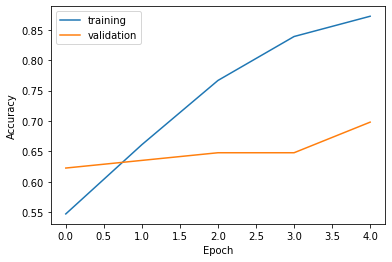

In [232]:
# Plot the training and validation accuracy

plt.plot(history.epoch, history.history['accuracy'], label='training')
plt.plot(history.epoch, history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy');